In [86]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import os
import time

from keras.layers import Input, Dense,MaxPooling2D,Flatten, Conv2D,BatchNormalization,Activation
from keras.models import Model

In [87]:
train_data_dir = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Train/'
dev_data_dir = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Dev/'
test_data_dir = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Test/'

# dimensions of the images.
#img_width, img_height = 240, 150

N_train_samples = 47922
N_dev_samples = 4018
N_test_samples = 10798

print(N_train_samples+N_dev_samples)

51940


In [88]:
## Parse labels file
file = open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Labels_train.txt', 'r') 
labels_train = file.read().split()
file.close()
labels_train = np.asarray(labels_train).astype('float32')

## Parse labels file
file = open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/Labels_dev.txt', 'r') 
labels_dev = file.read().split()
file.close()
labels_dev = np.asarray(labels_dev).astype('float32')


file = open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/T_train.txt', 'r') 
T_train = file.read().split()
file.close()
T_train = np.asarray(T_train).astype('float32')

file = open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/T_dev.txt', 'r') 
T_dev = file.read().split()
file.close()
T_dev = np.asarray(T_dev).astype('float32')

In [89]:
pred_speed_T = []
for i in np.arange(1,10,1):
    file = open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/predictions/train'+ str(i) + '.txt', 'r') 
    pred_speed = file.read().split()
    file.close()
    pred_speed = np.asarray(pred_speed).astype('float32')
    
    pred_speed_T.append(pred_speed)
    
pred_speed_T = np.asarray(pred_speed_T)

In [34]:
print(pred_speed_T.shape)

(9, 47922)


In [45]:
pred_speed_D = []
for i in np.arange(0,10,1):
    file = open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/predictions/dev'+ str(i) + '.txt', 'r') 
    pred_speed = file.read().split()
    file.close()
    pred_speed = np.asarray(pred_speed).astype('float32')
    
    pred_speed_D.append(pred_speed)
pred_speed_D = np.asarray(pred_speed_D)

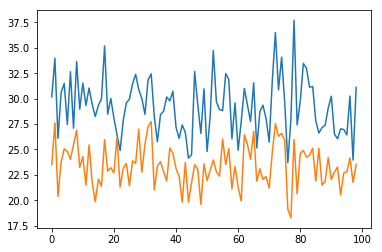

In [46]:
plt.plot(pred_speed_T[1,1:100])
plt.plot(pred_speed_T[2,1:100])

In [47]:
array_boost_D = np.mean(pred_speed_D,axis = 0)
array_boost_T = np.mean(pred_speed_T,axis = 0)


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.signal import medfilt
                     
for i in range(len(pred_speed_T)):
    mse_train = np.mean((pred_speed_T[i,:]-labels_train)**2)
    #mse_dev = np.mean((pred_speed_D[i,:]-labels_dev)**2)
    mse_dev = 0
    print('Train %.2f, Test %.2f'%(mse_train,mse_dev))
    
print('Estimated MSE Train: %.2f' %np.mean((array_boost_T-labels_train)**2))
print('Estimated MSE Dev:  %.2f'%np.mean((array_boost_D-labels_dev)**2))

Train 14.07, Test 0.00
Train 28.85, Test 0.00
Train 7.28, Test 0.00
Train 10.65, Test 0.00
Train 7.81, Test 0.00
Train 13.01, Test 0.00
Train 16.46, Test 0.00
Train 20.13, Test 0.00
Train 7.90, Test 0.00
Estimated MSE Train: 4.40
Estimated MSE Dev:  12.31


In [74]:
import scipy.signal as sig

def util_lowpass(signal_raw,fps,hicut,order):
    mean_calc = np.mean(signal_raw) # subtract and add back mean
    S = signal_raw - mean_calc
    b, a = sig.butter(order,hicut/fps,'lowpass')
    signal_filt = sig.filtfilt(b,a,S)
    return signal_filt + mean_calc

dev_filt = util_lowpass(array_boost_D,20,0.4,1)
print(np.mean((labels_dev-dev_filt)**2))

train_filt = util_lowpass(array_boost_T,20,0.4,1)
print(np.mean((labels_train-train_filt)**2))

7.297635025918907
2.0279899495299647


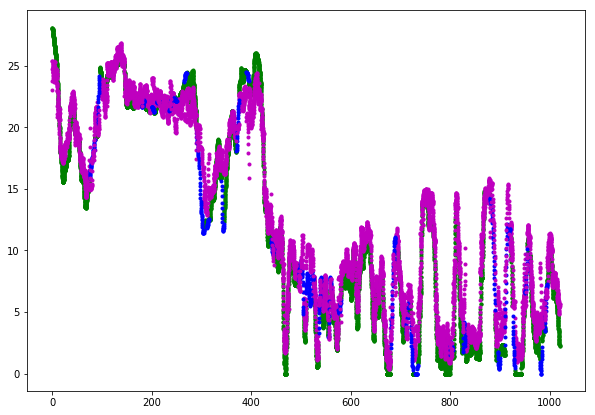

In [110]:
plt.figure(figsize = (10,7))
sp = 5
#plt.plot(T_train[::sp],array_boost_T[::sp],'b.')
plt.plot(T_train[::sp],labels_train[::sp],'g.')
plt.plot(T_train[::sp],train_filt[::sp],'m.')

#plt.plot(T_dev[::sp],array_boost_D[::sp],'g.')
plt.plot(T_dev[::sp],labels_dev[::sp],'b.')
plt.plot(T_dev[::sp],dev_filt[::sp],'m.')

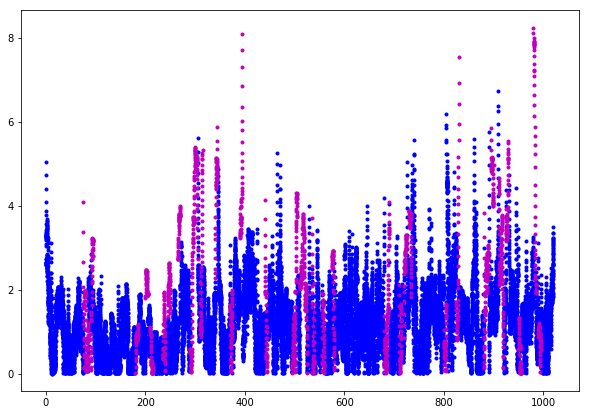

In [85]:
plt.figure(figsize = (10,7))
sp = 2
#plt.plot(T_train[::sp],array_boost_T[::sp],'b.')
plt.plot(T_train[::sp],np.abs(labels_train[::sp]-train_filt[::sp]),'b.')

#plt.plot(T_dev[::sp],array_boost_D[::sp],'g.')
plt.plot(T_dev[::sp],np.abs(labels_dev[::sp]-dev_filt[::sp]),'m.')


## Process the test set

In [105]:
pred_speed_F = []

for i in np.arange(0,13,1):
    file = open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/predictions/test'+ str(i) + '.txt', 'r') 
    pred_speed = file.read().split()
    file.close()
    pred_speed = np.asarray(pred_speed).astype('float32')
    
    pred_speed_F.append(pred_speed)

pred_speed_F = np.asarray(pred_speed_F)

In [113]:
array_boost_TEST = np.mean(pred_speed_F,axis = 0)
test_filt = util_lowpass(array_boost_TEST,20,0.4,1)


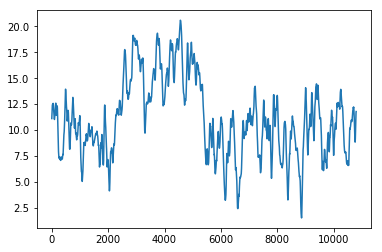

In [114]:
plt.plot(test_filt)

In [115]:
print(len(test_filt))

10798


In [119]:
test_write = test_filt.astype('float32')
with open('/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/test.txt', 'w') as f:
    for item in test_write:
        f.write("%s\n" % item)